In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/news.csv')

In [6]:
df.shape # checking for total no. of articles

(6335, 4)

In [7]:
df.head() # checking for order

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [8]:
df.isnull().sum() # Checking for null entries

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
import string # function defined to clean dataset
def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    words = words.replace('—','')
    return words

df['text'] = df['text'].apply(clean_text)
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,daniel greenfield a shillman journalism f...,FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,us secretary of state john f kerry said...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 ...,FAKE
4,875,The Battle of New York: Why This Primary Matters,its primary day in new york and frontru...,REAL


In [10]:
from sklearn.model_selection import train_test_split

In [12]:
train, test = train_test_split(df, test_size = 0.07)
train, validation = train_test_split(train, test_size = 0.03) # split into training, validation and test sets 

In [13]:
train.head()

,Unnamed: 0,title,text,label
2730,8822,Nestle to launch new non-GMO products ... How ...,nestle to launch new nongmo products h...,FAKE
3502,1614,The fourth GOP debate is more about the party’...,the leading republican presidential candid...,REAL
3025,1366,Rand Paul Drops Out Of White House Race,kentucky sen rand paul is suspending his...,REAL
1732,7971,Hillary cancels public appearance due to a lar...,memes breaking hillary cancels public app...,FAKE
5964,7717,Christie Lost Republicans The 2012 Election. H...,christie lost republicans the 2012 electi...,FAKE


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>" 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.text) # only text feature is used for training
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(np.array(train.text))
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [16]:
# setting the training inputs
train_x = np.copy(training_padded)
validate_x = np.copy(validation_padded)

In [17]:
# setting the training targets
train_y = train['label'].replace('FAKE',1).replace('REAL',0).values
validate_y = validation['label'].replace('FAKE',1).replace('REAL',0).values

### Defining the model

In [19]:
import tensorflow as tf

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

### Training the model

In [22]:
history = model.fit(train_x, train_y, verbose = 2, epochs = 10, validation_data = (validate_x, validate_y),
                   callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])

Epoch 1/10
179/179 - 61s - loss: 0.6502 - accuracy: 0.6587 - val_loss: 0.5760 - val_accuracy: 0.7627
Epoch 2/10
179/179 - 60s - loss: 0.4013 - accuracy: 0.8490 - val_loss: 0.3874 - val_accuracy: 0.8362
Epoch 3/10
179/179 - 61s - loss: 0.2336 - accuracy: 0.9204 - val_loss: 0.2867 - val_accuracy: 0.9040
Epoch 4/10
179/179 - 60s - loss: 0.1457 - accuracy: 0.9596 - val_loss: 0.2357 - val_accuracy: 0.9379
Epoch 5/10
179/179 - 60s - loss: 0.0910 - accuracy: 0.9785 - val_loss: 0.2177 - val_accuracy: 0.9492
Epoch 6/10
179/179 - 60s - loss: 0.0566 - accuracy: 0.9911 - val_loss: 0.2020 - val_accuracy: 0.9492
Epoch 7/10
179/179 - 60s - loss: 0.0359 - accuracy: 0.9961 - val_loss: 0.2095 - val_accuracy: 0.9548
Epoch 8/10
179/179 - 60s - loss: 0.0229 - accuracy: 0.9988 - val_loss: 0.2077 - val_accuracy: 0.9548
Epoch 9/10
179/179 - 60s - loss: 0.0147 - accuracy: 0.9998 - val_loss: 0.2138 - val_accuracy: 0.9435
Epoch 10/10
179/179 - 61s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.2159 - val_accura

### Predicting using test data

In [24]:
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)
preds = np.round(model.predict(test_padded))
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["label"].replace('FAKE',1).replace('REAL',0).values)) / len(test)
print("Accuracy of the mode is: ", acc )

Accuracy of the mode is:  0.9256756756756757


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


### Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [26]:
TN, FP, FN, TP = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds).ravel()
cm = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds)

(0.0, 1.0, 0.0, 1.0)

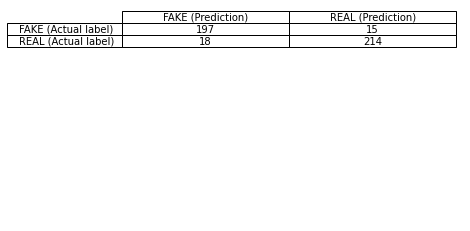

In [29]:
plt.table(cellText=[[TP,FN],[FP,TN]],cellLoc='center',colWidths=[0.5,0.5],rowLabels=['FAKE (Actual label)','REAL (Actual label)'],colLabels=['FAKE (Prediction)','REAL (Prediction)'],loc=0)
plt.axis('off')